In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install imgaug

In [4]:
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [84]:
import os
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from skimage import color, util, feature
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import imgaug as ia
import imgaug.augmenters as iaa
import shutil
import zipfile
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label
from skimage import img_as_ubyte
from skimage.measure import shannon_entropy
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
import urllib.request

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [6]:
fno=[]
for dirname, _, filenames in os.walk('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'):
    for filename in filenames:
        a= os.path.join(dirname, filename)
        fno.append(a)
len(fno),fno[1]   

(98, '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG')

In [7]:
fyes=[]
for dirname, _, filenames in os.walk('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'):
    for filename in filenames:
        a= os.path.join(dirname, filename)
        fyes.append(a)
len(fyes),fyes[1] 

(155, '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y192.JPG')

In [8]:
z = ['no']* len(fno)
one = ['yes']*len(fyes)

In [9]:
dfn = pd.DataFrame(list(zip(fno, z)), columns=['filepath', 'tumor'])
dfy = pd.DataFrame(list(zip(fyes, one)), columns=['filepath', 'tumor'])

df = pd.concat([dfn, dfy], ignore_index=True)
df.head()


,filepath,tumor
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no


In [10]:
path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

In [11]:
Size=150
images=[]
labels=[]
name_fol = ['no', 'yes']

for folder in name_fol:
    path_ = os.path.join(path, folder)
    for file in os.listdir(path_):
        path2 = os.path.join(path_, file)
        image = cv2.imread(path2)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (Size, Size))
        images.append(image)
        labels.append(folder)

images = np.array(images)
labels = np.array(labels)

In [12]:
images.shape

(253, 150, 150, 3)

## Augmentation

In [13]:
# Assume 'images' is your original dataset

# Define data augmentation pipeline
aug = iaa.Sequential([
    iaa.Fliplr(),
    iaa.Affine(rotate=(-30, 30)),
    iaa.GaussianBlur(sigma=(0, 1.0)),
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
])

num_augmented_images = 4

augmented_images = []

# Create folders to store augmented images
output_folder_no = "augmented_images/no"
output_folder_yes = "augmented_images/yes"
os.makedirs(output_folder_no, exist_ok=True)
os.makedirs(output_folder_yes, exist_ok=True)

# Augment and save images
for i in range(len(images)):
    current_image = images[i]
    current_label = labels[i]
    augmented_images.append(current_image)

    for j in range(num_augmented_images):
        augmented = aug(images=[current_image])[0]
        augmented_images.append(augmented)
        
        if current_label == 'no':
            folder_path = output_folder_no
        elif current_label == 'yes':
            folder_path = output_folder_yes
        else:
            raise ValueError("Invalid label")

        cv2.imwrite(os.path.join(folder_path, f"augmented_image_{i}_{j}.png"), augmented)

images_aug = np.array(augmented_images)

# Rest of the code remains the same for creating a ZIP file
zip_filename = "augmented_data.zip"
zip_path = os.path.join("augmented_images", zip_filename)

with zipfile.ZipFile(zip_path, 'w') as zip_file:
    for root, _, files in os.walk("augmented_images"):
        for file in files:
            file_path = os.path.join(root, file)
            zip_file.write(file_path, arcname=os.path.relpath(file_path, "augmented_images"))

# Users can manually download the ZIP file from the specified path
print(f"ZIP file created: {zip_path}")

ZIP file created: augmented_images/augmented_data.zip


In [14]:
# data augmentation
aug = iaa.Sequential([
    iaa.Fliplr(),  # Flip 
    iaa.Affine(rotate=(-30, 30)),  # Rotasi -30 - 30 degree
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Blur antara 0 - 1
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),  # Noise prob 50%
])

num_augmented_images = 4

augmented_images = []
augmented_labels = []

for i in range(len(images)):
    current_image = images[i]
    current_label = labels[i]

    augmented_images.append(current_image)
    augmented_labels.append(current_label)

    for _ in range(num_augmented_images):
        augmented = aug(images=[current_image])[0]  
        augmented_images.append(augmented)
        augmented_labels.append(current_label)

images_aug = np.array(augmented_images)
labels_aug = np.array(augmented_labels)

In [15]:
print('Images Shape :',images_aug.shape)
print('Labels Shape :',labels_aug.shape)

Images Shape : (1265, 150, 150, 3)
Labels Shape : (1265,)


## Convert to gray

In [16]:
images_aug = np.array([cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY) for color_image in images_aug])

In [17]:
print('Images Shape :',images_aug.shape)
print('Labels Shape :',labels_aug.shape)

Images Shape : (1265, 150, 150)
Labels Shape : (1265,)


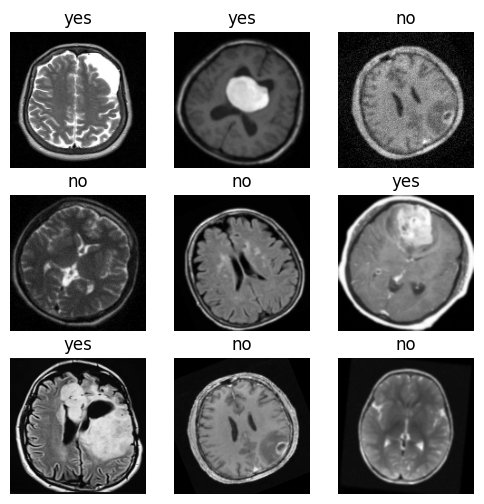

In [18]:
plt.figure(figsize=(6,6))
x = 1
for i in np.random.randint(0,len(images_aug),9):
    plt.subplot(3, 3, x)
    plt.imshow(images_aug[i], cmap='gray')
    plt.title(labels_aug[i])
    plt.axis('off')    
    x += 1

## Splitting

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images_aug, labels_aug, test_size=.2, shuffle=True)

In [20]:
len(X_test)

253

<BarContainer object of 2 artists>

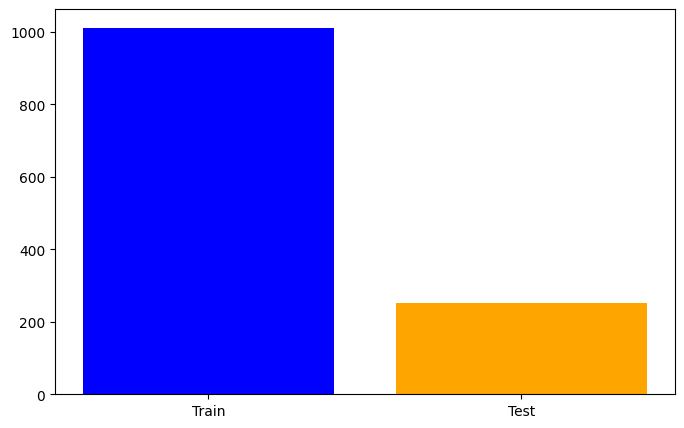

In [21]:
# Nama kategori
categories = ['Train', 'Test']

# Jumlah data
data_lengths = [len(X_train), len(X_test)]
colors = ['blue', 'orange']

# Membuat diagram batang
plt.figure(figsize=(8, 5))
plt.bar(categories, data_lengths, color=colors)

# # Menambahkan label dan judul
# plt.xlabel('Kategori')
# plt.ylabel('Panjang Data')
# plt.title('Panjang Data Train dan Test')

## Shape Extraction

In [22]:
def extract_shape_features(image):
    edges = cv2.Canny(image, 100, 500)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Inisialisasi list untuk menyimpan fitur
    features = []
    
    # Loop melalui setiap kontur
    for contour in contours:
        # Hitung panjang lengkungan (perimeter)
        perimeter = cv2.arcLength(contour, True)
        
        # Hitung luas kontur
        area = cv2.contourArea(contour)
        
        # Hitung bentuk persegi panjang yang melingkupi kontur
        x, y, w, h = cv2.boundingRect(contour)
        
        # Hitung aspek rasio kontur
        aspect_ratio = float(w) / h if h != 0 else 0
        
        # Simpan fitur ke dalam list
        features.extend([perimeter, area, aspect_ratio, w, h])
    
    return features

def create_tabular_data(images):
    # Mengekstraksi fitur dari setiap gambar
    all_features = []
    for image in images:
        features = extract_shape_features(image)
        all_features.append(features)
    
    # Memastikan bahwa semua baris memiliki jumlah fitur yang sama
    max_features = max(len(features) for features in all_features)
    for features in all_features:
        while len(features) < max_features:
            features.append(np.nan)
    
    # Menyusun data tabular
    columns = [f'Feature_{i}' for i in range(max_features)]
    df = pd.DataFrame(all_features, columns=columns)
    
    # Memilih hanya 5 kolom yang diinginkan
    selected_columns = df.iloc[:, :5]
    
    return selected_columns

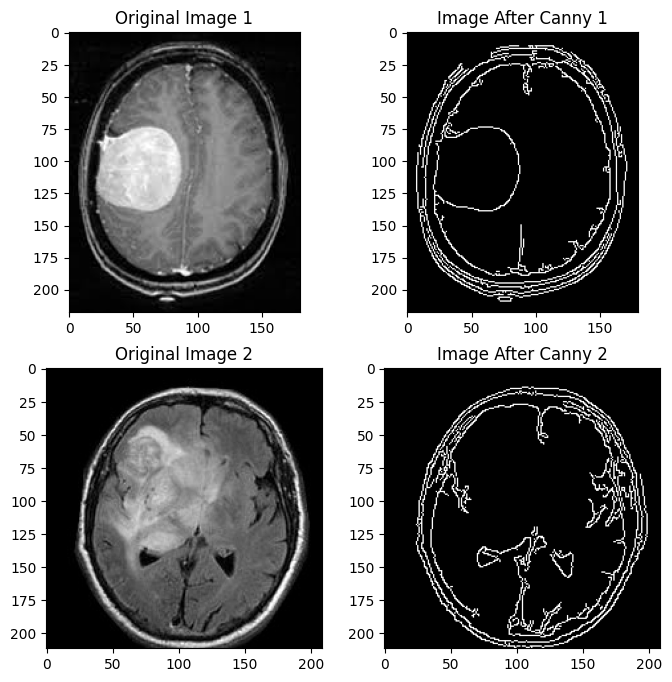

In [23]:
# Example usage with a list of image paths
image_paths = ['/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg', '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y2.jpg']

# Read images from paths
images_plot = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]

def visualize_images_after_canny(images):
    # Create a figure for the plot with a certain number of columns
    num_columns = 2
    num_rows = len(images) // num_columns + 1
    plt.figure(figsize=(8, 8))

    for i, image in enumerate(images, start=1):
        # Apply Canny edge detection
        edges = cv2.Canny(image, 100, 500)

        # Plot the original image
        plt.subplot(num_rows, num_columns, i * 2 - 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Original Image {i}')

        # Plot the image after Canny edge detection
        plt.subplot(num_rows, num_columns, i * 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Image After Canny {i}')

    plt.show()

# Example usage
visualize_images_after_canny(images_plot)

In [24]:
X_train_shape = create_tabular_data(X_train)
X_test_shape = create_tabular_data(X_test)

In [25]:
print('Images Shape Extraction Train Shape :',X_train_shape.shape)
print('Images Shape Extraction Test Shape :',X_test_shape.shape)

Images Shape Extraction Train Shape : (1012, 5)
Images Shape Extraction Test Shape : (253, 5)


In [26]:
cols = {'Feature_0': 'Perimeter',
        'Feature_1': 'Area',
        'Feature_2': 'Aspect Ratio',
        'Feature_3': 'Bounding Rectangle Width',
        'Feature_4': 'Bounding Rectangle Height'
}

In [27]:
X_train_shape.columns = [cols[col] if col in cols else col for col in X_train_shape.columns]
X_test_shape.columns = [cols[col] if col in cols else col for col in X_test_shape.columns]

In [28]:
X_train_shape.head()

,Perimeter,Area,Aspect Ratio,Bounding Rectangle Width,Bounding Rectangle Height
0,641.470124,10940.0,0.726619,101.0,139.0
1,298.000000,0.0,150.000000,150.0,1.0
2,189.865006,38.5,0.808824,55.0,68.0
3,76.769552,19.0,1.636364,18.0,11.0
4,14.242641,12.5,1.000000,5.0,5.0


## Ekstraksi Tekstur GLCM

In [29]:
def feature_extractor(dataset):
    feature_dataset = pd.DataFrame()
    
    for image in range(dataset.shape[0]):
        df = pd.DataFrame()
        
        img = dataset[image, :, :]
        
        # Convert the image to unsigned integer type
        img = img_as_ubyte(img)
        
        # Ekstraksi fitur Sobel
        sobel_image = sobel(img)
        
        # Ekstraksi fitur GLCM pada citra asli
        GLCM = graycomatrix(img, [1], [0])       
        GLCM_Energy = graycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = graycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr       
        GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss       
        GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom       
        GLCM_contr = graycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr
        GLCM_entropy = shannon_entropy(GLCM)
        df['Entropy'] = GLCM_entropy
        
        # Ekstraksi fitur GLCM pada citra hasil Sobel
        sobel_image = sobel(img)
        sobel_image_uint8 = img_as_ubyte(sobel_image)  # Convert to unsigned byte
        GLCM_sobel = graycomatrix(sobel_image_uint8, [3], [0])

        GLCM_Energy_sobel = graycoprops(GLCM_sobel, 'energy')[0]
        df['Energy_sobel'] = GLCM_Energy_sobel
        GLCM_corr_sobel = graycoprops(GLCM_sobel, 'correlation')[0]
        df['Corr_sobel'] = GLCM_corr_sobel       
        GLCM_diss_sobel = graycoprops(GLCM_sobel, 'dissimilarity')[0]
        df['Diss_sim_sobel'] = GLCM_diss_sobel       
        GLCM_hom_sobel = graycoprops(GLCM_sobel, 'homogeneity')[0]
        df['Homogen_sobel'] = GLCM_hom_sobel       
        GLCM_contr_sobel = graycoprops(GLCM_sobel, 'contrast')[0]
        df['Contrast_sobel'] = GLCM_contr_sobel
        GLCM_entropy_sobel = shannon_entropy(GLCM_sobel)
        df['Entropy_sobel'] = GLCM_entropy_sobel
        
        feature_dataset = pd.concat([feature_dataset, df], ignore_index=True)
        
    return feature_dataset

In [87]:
def show_image(image,title="Image"):
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show

def show_heatmap(matrix,title="Heatmap"):
    plt.imshow(cv2.cvtColor(matrix,cv2.COLOR_BGR2RGB),interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.show()

Contrast: 241.7948336835631
Energy: 0.0922131808605866
Homogeneity: 0.3430007824392834
Correlation: 0.9749408188184336
Dissimilarity: 7.955461021987597
Entropy: 1.3587560683896691


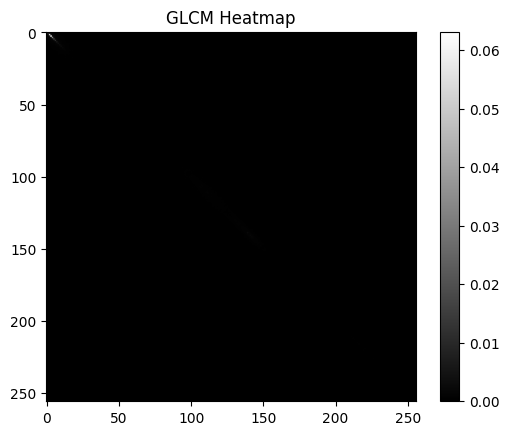

In [94]:
import cv2
from skimage import feature
import matplotlib.pyplot as plt

def extract_texture_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = feature.graycomatrix(gray_image, [1], [0], symmetric=True, normed=True)
    contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
    energy = feature.graycoprops(glcm, 'energy')[0, 0]
    homogeneity = feature.graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    GLCM_diss = graycoprops(glcm, 'dissimilarity')[0, 0]
    GLCM_entropy_sobel = shannon_entropy(glcm)
    print(f"Contrast: {contrast}")
    print(f"Energy: {energy}")
    print(f"Homogeneity: {homogeneity}")
    print(f"Correlation: {correlation}")
    print(f"Dissimilarity: {GLCM_diss}")
    print(f"Entropy: {GLCM_entropy_sobel}")
    show_heatmap(glcm[:, :, 0, 0], "GLCM Heatmap")

def show_heatmap(heatmap, title):
    plt.imshow(heatmap, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

imgsd = cv2.imread("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg")
converted_image = cv2.convertScaleAbs(imgsd)
extract_texture_features(converted_image)

In [30]:
X_train_texture = feature_extractor(X_train)
X_test_texture = feature_extractor(X_test)

In [31]:
print('Images Texture Extraction Train Shape :',X_train_texture.shape)
print('Images Texture Extraction Test Shape :',X_test_texture.shape)

Images Texture Extraction Train Shape : (1012, 12)
Images Texture Extraction Test Shape : (253, 12)


In [32]:
X_train_texture.head()

,Energy,Corr,Diss_sim,Homogen,Contrast,Entropy,Energy_sobel,Corr_sobel,Diss_sim_sobel,Homogen_sobel,Contrast_sobel,Entropy_sobel
0,0.244763,0.923427,7.854228,0.485282,273.681342,0.611613,0.274660,0.546462,8.526576,0.416260,260.624263,0.453024
1,0.235526,0.942539,8.730694,0.405081,365.066443,0.668620,0.192877,0.564493,14.299365,0.337831,769.606667,0.537055
2,0.089925,0.970640,5.045414,0.425064,102.922908,0.581572,0.137110,0.507110,7.354467,0.351143,194.474921,0.393124
3,0.128650,0.928289,7.624966,0.361398,213.392036,0.619386,0.135982,0.462024,10.678730,0.285630,331.076553,0.495769
4,0.054970,0.845772,13.513870,0.241506,717.088635,0.750477,0.068949,0.480325,15.149524,0.223937,761.387710,0.625842


## Gabungkan Data Hasil Ekstraksi

In [33]:
X_train = pd.concat([X_train_shape, X_train_texture], axis=1)
X_test = pd.concat([X_test_shape, X_test_texture], axis=1)

In [34]:
print('Images Train Shape :',X_train.shape)
print('Images Extraction Test Shape :',X_test.shape)

Images Train Shape : (1012, 17)
Images Extraction Test Shape : (253, 17)


In [35]:
X_train.head()

,Perimeter,Area,Aspect Ratio,Bounding Rectangle Width,Bounding Rectangle Height,Energy,Corr,Diss_sim,Homogen,Contrast,Entropy,Energy_sobel,Corr_sobel,Diss_sim_sobel,Homogen_sobel,Contrast_sobel,Entropy_sobel
0,641.470124,10940.0,0.726619,101.0,139.0,0.244763,0.923427,7.854228,0.485282,273.681342,0.611613,0.274660,0.546462,8.526576,0.416260,260.624263,0.453024
1,298.000000,0.0,150.000000,150.0,1.0,0.235526,0.942539,8.730694,0.405081,365.066443,0.668620,0.192877,0.564493,14.299365,0.337831,769.606667,0.537055
2,189.865006,38.5,0.808824,55.0,68.0,0.089925,0.970640,5.045414,0.425064,102.922908,0.581572,0.137110,0.507110,7.354467,0.351143,194.474921,0.393124
3,76.769552,19.0,1.636364,18.0,11.0,0.128650,0.928289,7.624966,0.361398,213.392036,0.619386,0.135982,0.462024,10.678730,0.285630,331.076553,0.495769
4,14.242641,12.5,1.000000,5.0,5.0,0.054970,0.845772,13.513870,0.241506,717.088635,0.750477,0.068949,0.480325,15.149524,0.223937,761.387710,0.625842


## Visualization

In [ ]:
coba = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)

In [ ]:
coba.columns

In [ ]:
cols = [                'Perimeter',                      'Area',
                    'Aspect Ratio',  'Bounding Rectangle Width',
       'Bounding Rectangle Height',                    'Energy',
                            'Corr',                  'Diss_sim',
                         'Homogen',                  'Contrast',
                         'Entropy',              'Energy_sobel',
                      'Corr_sobel',            'Diss_sim_sobel',
                   'Homogen_sobel',            'Contrast_sobel',
                   'Entropy_sobel']

In [ ]:
coba = coba.rename({coba.columns[-1]: 'Tumor'})

In [ ]:
coba.head()

In [ ]:
sns.pairplot(coba)

In [ ]:
num_cols = len(coba.columns)

# Tentukan ukuran nrows dan ncols berdasarkan jumlah kolom
nrows = (num_cols - 1) // 3 + 1
ncols = min(num_cols, 3)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 7))

for i, col in enumerate(coba.columns):
    sns.histplot(x=col, data=coba, ax=axes[i // ncols, i % ncols], kde=True, stat="density", linewidth=0)
plt.tight_layout()
plt.show()

In [ ]:
coba.select_dtypes('number').corr()

## Preprocessing Tabular Data

In [36]:
X_train.isna().sum()

Perimeter                    10
Area                         10
Aspect Ratio                 10
Bounding Rectangle Width     10
Bounding Rectangle Height    10
Energy                        0
Corr                          0
Diss_sim                      0
Homogen                       0
Contrast                      0
Entropy                       0
Energy_sobel                  0
Corr_sobel                    0
Diss_sim_sobel                0
Homogen_sobel                 0
Contrast_sobel                0
Entropy_sobel                 0
dtype: int64

In [37]:
X_test.isna().sum()

Perimeter                    3
Area                         3
Aspect Ratio                 3
Bounding Rectangle Width     3
Bounding Rectangle Height    3
Energy                       0
Corr                         0
Diss_sim                     0
Homogen                      0
Contrast                     0
Entropy                      0
Energy_sobel                 0
Corr_sobel                   0
Diss_sim_sobel               0
Homogen_sobel                0
Contrast_sobel               0
Entropy_sobel                0
dtype: int64

In [38]:
# impute
X_train = X_train.interpolate()
X_test = X_test.interpolate()

In [39]:
# encoding
encoding_map = {'no': 0, 'yes': 1}

y_train = np.vectorize(encoding_map.get)(y_train)
y_test = np.vectorize(encoding_map.get)(y_test)

In [40]:
# normalisasi
mms = MinMaxScaler()
ss = StandardScaler()
nor = Normalizer()
rs = RobustScaler()

X_train_scaled = mms.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test_scaled = mms.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [41]:
X_train_scaled.head()

,Perimeter,Area,Aspect Ratio,Bounding Rectangle Width,Bounding Rectangle Height,Energy,Corr,Diss_sim,Homogen,Contrast,Entropy,Energy_sobel,Corr_sobel,Diss_sim_sobel,Homogen_sobel,Contrast_sobel,Entropy_sobel
0,0.309365,0.499145,0.004370,0.671141,0.926174,0.329704,0.699517,0.304314,0.622566,0.109691,0.370706,0.400707,0.784582,0.195614,0.557478,0.089581,0.421279
1,0.143718,0.000000,1.000000,1.000000,0.000000,0.316528,0.784920,0.359044,0.500510,0.152647,0.465131,0.270069,0.815354,0.459344,0.424998,0.325443,0.595803
2,0.091567,0.001757,0.004918,0.362416,0.449664,0.108823,0.910488,0.128918,0.530922,0.029425,0.320946,0.180988,0.717425,0.142067,0.447484,0.058928,0.296872
3,0.037024,0.000867,0.010438,0.114094,0.067114,0.164066,0.721243,0.289997,0.434031,0.081351,0.383581,0.179186,0.640483,0.293935,0.336821,0.122229,0.510056
4,0.006869,0.000570,0.006193,0.026846,0.026846,0.058958,0.352510,0.657728,0.251569,0.318116,0.600716,0.072110,0.671716,0.498183,0.232612,0.321634,0.780206


## Tree Models

In [59]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
rf_pred_test = rf.predict(X_test)

In [60]:
test_acc = accuracy_score(y_test, rf_pred_test)
test_acc

0.5217391304347826

In [51]:
xgb_params = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 60, 'min_child_weight': 1}
xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train_scaled, y_train)
xgb_pred_test = xgb.predict(X_test_scaled)

In [52]:
accuracy_score(y_test, xgb_pred_test)

0.758893280632411

In [78]:
catboost_model = CatBoostClassifier()

catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

y_train_pred = catboost_model.predict(X_train)

y_val_pred = catboost_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_test, y_val_pred)

print(f'Validation Accuracy: {val_acc:.2f}')
print(f'Validation Accuracy: {val_acc:.2f}')


Learning rate set to 0.031783
0:	learn: 0.6824088	test: 0.6830554	best: 0.6830554 (0)	total: 3.22ms	remaining: 3.22s
100:	learn: 0.3734496	test: 0.4702881	best: 0.4702881 (100)	total: 289ms	remaining: 2.58s
200:	learn: 0.2765178	test: 0.4412923	best: 0.4397257 (195)	total: 567ms	remaining: 2.25s
300:	learn: 0.2073563	test: 0.4199877	best: 0.4199877 (300)	total: 851ms	remaining: 1.98s
400:	learn: 0.1539079	test: 0.4079062	best: 0.4079062 (400)	total: 1.13s	remaining: 1.69s
500:	learn: 0.1152931	test: 0.3999214	best: 0.3993730 (496)	total: 1.41s	remaining: 1.4s
600:	learn: 0.0890265	test: 0.3961262	best: 0.3950359 (564)	total: 1.69s	remaining: 1.12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3950359238
bestIteration = 564

Shrink model to first 565 iterations.
Validation Accuracy: 0.80
Validation Accuracy: 0.80


In [79]:
precision_score(y_test, y_val_pred)

0.8433734939759037

In [80]:
recall_score(y_test, y_val_pred)

0.8536585365853658

In [81]:
print(classification_report(y_test, y_val_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72        89
           1       0.84      0.85      0.85       164

    accuracy                           0.80       253
   macro avg       0.78      0.78      0.78       253
weighted avg       0.80      0.80      0.80       253



In [ ]:
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', verbose=1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_

print("Parameter Terbaik:", best_params)

## Logistic Regression

In [ ]:
lr = LogisticRegressionCV()
lr.fit(X_train_scaled, y_train)
lr_pred_train = lr.predict(X_train_scaled)
lr_pred_test = lr.predict(X_test_scaled)

In [ ]:
accuracy_score(y_train, lr_pred_train)

In [ ]:
accuracy_score(y_test, lr_pred_test)

## Support Vector Machine

In [ ]:
svm = SVC()
svm.fit(X_train_scaled, y_train)
svm_pred_train = svm.predict(X_train_scaled)
svm_pred_test = svm.predict(X_test)

In [ ]:
accuracy_score(y_train, svm_pred_train)

In [ ]:
accuracy_score(y_test, svm_pred_test)

## Do cross validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pred_rf_cv = cross_val_predict(xgb, X_train, y_train, cv=kf)
pred_rf_cv.mean()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
# Melakukan prediksi pada data test
predictions_test = rf.predict(X_test)

accuracy_test_cv = accuracy_score(y_test, predictions_test)
print(accuracy_test_cv)

## Neural Network

In [ ]:
# Define the path to your dataset
dataset_path = '/kaggle/working/augmented_images'

# Define the image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

In [ ]:
# Use ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Set the validation split percentage
)

In [ ]:
# Load the images from the directories
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

In [ ]:
print(train_generator.class_indices)

In [ ]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

In [ ]:
print(validation_generator.class_indices)

## Convolutional Neural Network

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (7, 7), strides=(1, 1), input_shape=(150, 150, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=3, name='bn0'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D((4, 4)))
model.add(tf.keras.layers.MaxPooling2D((4, 4)))

model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
# compile model
model.compile(loss='binary_crossentropy', # loss menggunakan binary crossentropy karena klasifikasi biner
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), # optimizer menggunakan RMSprop
              metrics=['accuracy']) # metrics menggunakan akurasi

In [ ]:
# training model dan simpan kedalam variabel hist
hist = model.fit(train_generator, epochs=50, verbose=1, validation_data=validation_generator)

In [ ]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Artificial Neural Network

In [ ]:
# Build the ANN model
model = tf.keras.models.Sequential()

# Input layer
model.add(Dense(units=2048, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dropout(0.5))  # Adding dropout for regularization

# Hidden layers
model.add(Dense(units=2048, activation='relu'))
model.add(Dense(units=1024, activation='relu'))

# Output layer (assuming binary classification)
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
hist_ann = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))

In [ ]:
# plot model performance
acc = hist_ann.history['accuracy']
val_acc = hist_ann.history['val_accuracy']
loss = hist_ann.history['loss']
val_loss = hist_ann.history['val_loss']
epochs_range = range(1, len(hist_ann.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Transfer Learning

In [ ]:
# download pretrained model
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(
inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [ ]:
# load model weight dari model Incecption yang telah di dowbload
local_weights_file = '/kaggle/working/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# deklarasikan model transfer learning dengan input shape 150x150x3 channel
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights = None)

# load weight dari file yang telah di download diawal
pre_trained_model.load_weights(local_weights_file)

In [ ]:
# looping pada setiap layer pada pre trained model dan buat model pretrain tidak meng train dengan kata lain freeze layer
# hal ini dilakukan bertujuan untuk menjaga weight dari InceptionV3 yang telah di train sebelumnya
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
# deklarasikan last layer
last_layer = pre_trained_model.get_layer('mixed7')
# tampilkan shape
print('output layer terakhir: ', last_layer.output_shape)
# buat output terakhir sama dengan output layer terakhir
last_output = last_layer.output

In [ ]:
# lakukan transfer learning
# buat arsitektur di fully connected layer

# lakukan flatten dari last output
x = tf.keras.layers.Flatten()(last_output)
# gunakan dense dengan units = 1024 dan activation relu
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# lakukan dropout untuk menghindari overfitting
x = tf.keras.layers.Dropout(0.2)(x)
# buat output layer dengan 1 neurion dengan activation function sigmoid karena binary classification
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# buat model dengan parameter yang telah dibuat sebelumnya
model = Model(pre_trained_model.input, x)

# cek summary dari model
model.summary()

In [ ]:
# atur parameter pada model
model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=0.0001), # gunakan optimizer RMSprop
              loss='binary_crossentropy', # karena binary classificaion
              metrics=['accuracy']) # karena klasifikasi

In [ ]:
# lakukan training model
hist_transfer_learning = model.fit(train_generator, validation_data=validation_generator, epochs=15, verbose=1)

In [ ]:
# plot model performance
acc = hist_transfer_learning.history['accuracy']
val_acc = hist_transfer_learning.history['val_accuracy']
loss = hist_transfer_learning.history['loss']
val_loss = hist_transfer_learning.history['val_loss']
epochs_range = range(1, len(hist_transfer_learning.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()